## Calculating return period for cyclones in Madagascar


Using their Database

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [8]:
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")

In [56]:
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

gdf_points = gpd.read_file(points_path)

In [23]:
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm2_BNGRC_OCHA_20181031.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [4]:
cyclone_db = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cyclone_database"
    / "Synthèse dégâts Climatiques 1997 - 2024 (OCHA).xlsx"
)
cyclone_db = pd.read_excel(cyclone_db, sheet_name="BDD").dropna(how="all")

In [5]:
cyclone_db["Categorie"].unique()

array(['Cyclone tropical', 'ZCIT', 'tempete tropicale',
       'Tempete tropicale', 'cyclone Tropical intense',
       'Perturbation tropicale', 'Forte tempete tropicale',
       'Cyclone tropical tres intense', 'Tempete tropicale Moderee',
       'Fortes pluies', 'Depression tropicale',
       'Depression tropicale Moderee', 'cyclone tropicale Moderee',
       'Cyclone tropical ', nan], dtype=object)

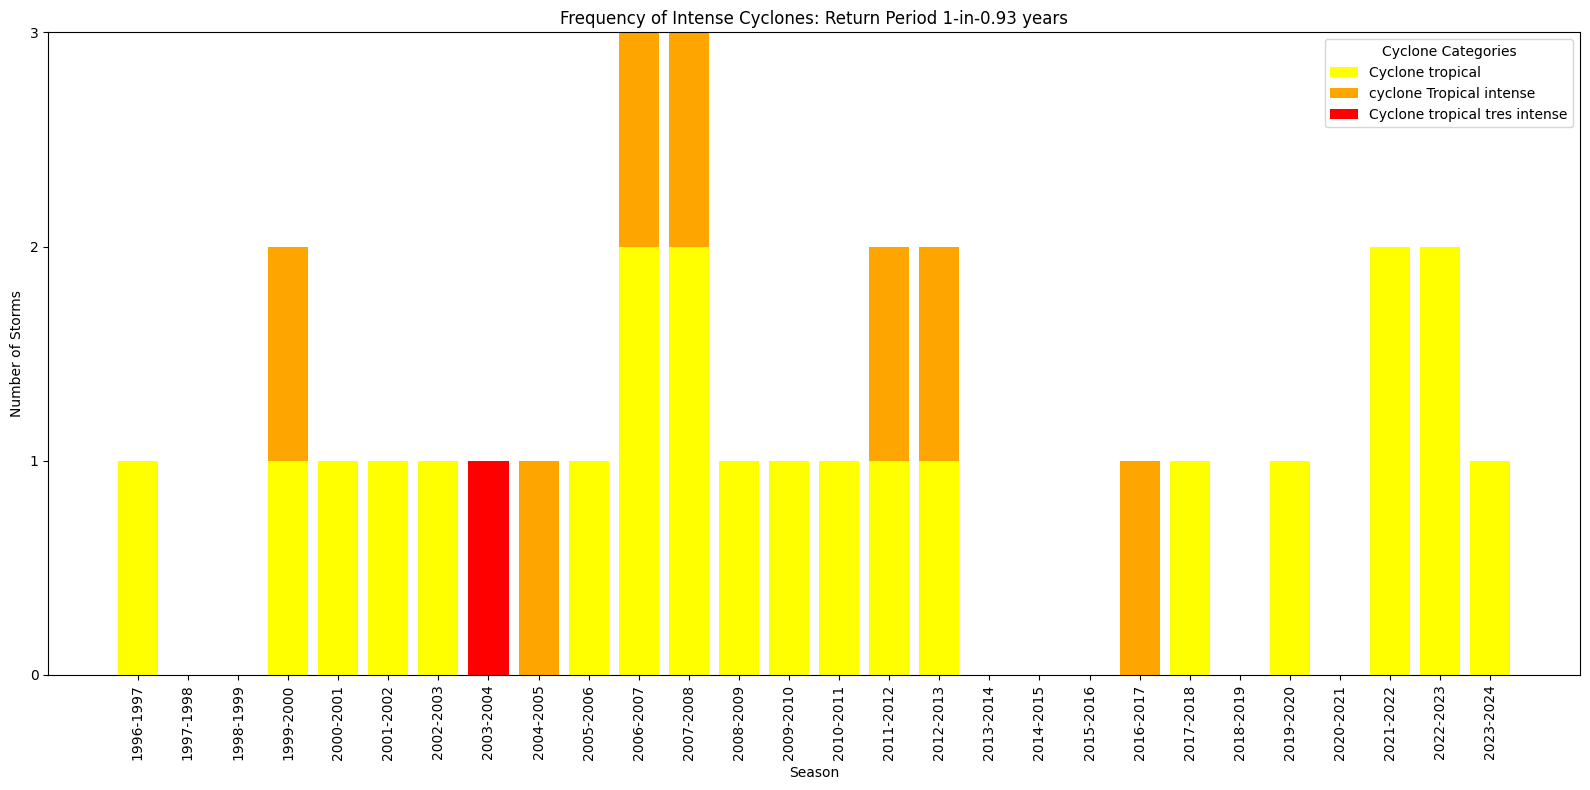

In [100]:
# Clean up the 'Categorie' column by stripping leading/trailing spaces
cyclone_db["Categorie"] = cyclone_db["Categorie"].str.strip()
# Filter intense storms
intense_storms = cyclone_db[
    cyclone_db["Categorie"].isin(
        [
            "Cyclone tropical",
            "cyclone Tropical intense",
            "Cyclone tropical tres intense",
            "Cyclone tropical ",
        ]
    )
]

# Generate a list of seasons from 1996/1997 to 2023/2024
start_years = range(1996, 2024)  # 1996 to 2023 as start years
seasons = [f"{year}-{year + 1}" for year in start_years]

# Create a DataFrame with all possible seasons
all_seasons = pd.DataFrame({"Saison": seasons})

# Count the number of intense storms per season and category
storm_frequency_per_year = (
    intense_storms.groupby(["Saison", "Categorie"])["Nom"]
    .nunique()
    .reset_index(name="Storm_Count")
)

# Merge with all_seasons to ensure all years are included for each category
storm_frequency_per_year = (
    pd.merge(
        all_seasons.assign(key=1),  # Create a key column for Cartesian product
        pd.DataFrame(storm_frequency_per_year.assign(key=1)),
        on=["Saison", "key"],
        how="left",
    )
    .fillna(0)
    .drop("key", axis=1)
)

# Calculate the overall return period (frequency)
total_years = all_seasons.shape[0]
total_storms = intense_storms["Nom"].nunique()
return_period = total_years / total_storms

# Set up a color map for each cyclone category
category_colors = {
    "Cyclone tropical": "yellow",
    "cyclone Tropical intense": "orange",
    "Cyclone tropical tres intense": "red",
}

# Pivot the data for easier plotting
pivot_data = storm_frequency_per_year.pivot(
    index="Saison", columns="Categorie", values="Storm_Count"
).fillna(0)

# Plot each category with its own color
plt.figure(figsize=(16, 8))
bottom = None  # To stack bars on top of each other

for category in category_colors:
    plt.bar(
        pivot_data.index,
        pivot_data[category],
        label=category,
        color=category_colors[category],
        bottom=bottom,
    )
    if bottom is None:
        bottom = pivot_data[category]
    else:
        bottom += pivot_data[category]

# Customize the plot
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Season")
plt.ylabel("Number of Storms")
plt.title(
    f"Frequency of Intense Cyclones: Return Period 1-in-{round(return_period, 2)} years"
)
plt.legend(title="Cyclone Categories")
plt.tight_layout()
plt.show()

In [34]:
cyclone_db["Nom"].unique()

array(['GRETELLE', 'MAUVAIS TEMPS', 'ELINE', 'GLORIA', 'ELINE & GLORIA',
       'HUDAH', 'Dera', 'Perturbation tropicale', 'KESINY', 'MANOU',
       'ELITA', 'GAFILO', 'ERNEST ET FELAPI', 'BOLOETSE', 'BONDO', 'JAYA',
       'clovis', 'INDLALA', 'IVAN', 'JOKWE', 'FAME', 'JADE', 'ASMA',
       'ERIC', 'FANELE', 'HUBERT', 'JOEL', 'FAMI', 'IZILDA', 'BINGIZA',
       'CHANDA', 'FUNSO', 'GIOVANNA', 'IRINA ZCIT', 'FELLENG', 'HARUNA',
       'DELIWE', 'PERTURBATION TROPICALE', 'HELLEN', 'CHEDZA',
       'INTEMPERIES', 'ZCIT', 'FUNDI', 'HALIBA', 'ENAWO', 'AVA-BERGUITA',
       'ELIAKIM', 'EKETSANG+ZCIT', 'MASSE NUAGEUSE', 'Belna',
       'Ex-Francisco', 'Francisco', 'Diane', 'Chalane', 'Eloise', 'Ana',
       'Batsirai', 'EMNATI', 'DUMAKO', 'GOMBE', 'JASMINE', 'CHENESO',
       'FREDDY', 'Alvaro', 'Gamane', nan], dtype=object)

In [31]:
# Group by the storm column (e.g., 'Nom') and count unique districts in 'Districts affectes'
storm_district_count = (
    cyclone_db.groupby("Nom")["Districts affectes"]
    .nunique()
    .reset_index(name="District_Count")
)

# Calculate the min, max, range, and mean of the district counts
district_min = storm_district_count["District_Count"].min()
district_max = storm_district_count["District_Count"].max()
district_range = district_max - district_min
district_mean = storm_district_count["District_Count"].mean()

# Display the results
print(f"Min number of districts affected: {district_min}")
print(f"Max number of districts affected: {district_max}")
print(f"Range of districts affected: {district_range}")
print(f"Mean number of districts affected per storm: {district_mean:.0f}")

Min number of districts affected: 1
Max number of districts affected: 84
Range of districts affected: 83
Mean number of districts affected per storm: 20


In [93]:
batsirai_points = gdf_points[
    (gdf_points["NAME"] == "BATSIRAI")
    & (gdf_points["LON"] <= 55)
    & (gdf_points["LAT"] >= -28)
]

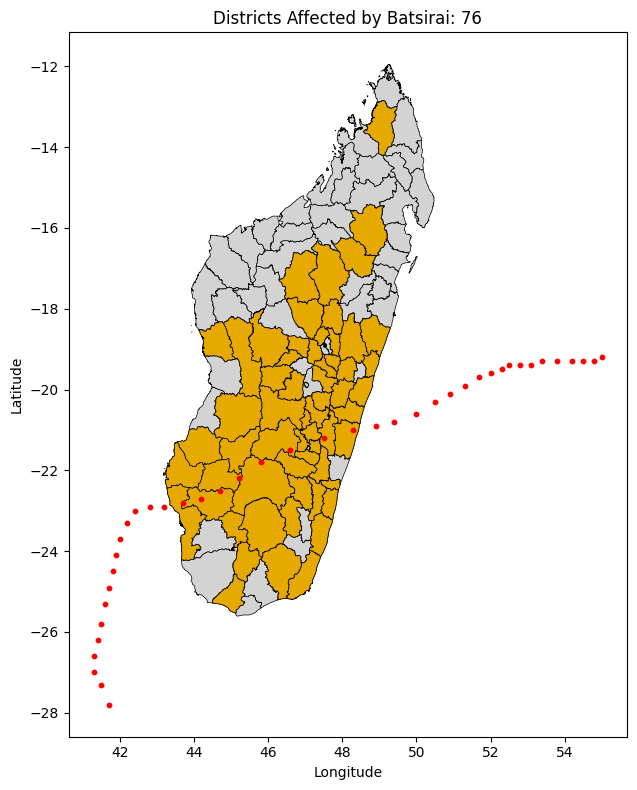

In [96]:
# Select the storm
storm_name = "Batsirai"
# Replace spaces with dashes in the cyclone database district names
cyclone_db["Districts affectes"] = cyclone_db[
    "Districts affectes"
].str.replace(" ", "-", regex=False)

affected_districts = cyclone_db[cyclone_db["Nom"] == storm_name][
    "Districts affectes"
].unique()

# Convert the affected districts to lowercase for matching consistency
affected_districts = [district.lower() for district in affected_districts]

# Load the administrative boundaries GeoDataFrame (gdf_adm2)
# Assuming gdf_adm2 has a column 'ADM2_EN' that corresponds to 'Districts affectes'
gdf_adm2["ADM2_EN"] = gdf_adm2[
    "ADM2_EN"
].str.lower()  # Convert to lowercase for matching

# Filter gdf_adm2 to get only the affected districts
affected_gdf = gdf_adm2[gdf_adm2["ADM2_EN"].isin(affected_districts)]

# Plot all districts with a neutral color (light grey)
plt.figure(figsize=(10, 8))
gdf_adm2.plot(ax=plt.gca(), color="#d3d3d3", edgecolor="black", linewidth=0.5)

# Overlay the affected districts with a single color (light burnt orange)
affected_gdf.plot(
    ax=plt.gca(), color="#e6a900", edgecolor="black", linewidth=0.5
)  # light burnt orange hex code
batsirai_points.plot(
    ax=plt.gca(), color="#FF0000", markersize=10, label="Storm Track Points"
)
# Customize the plot (remove legend)
plt.title(
    f"Districts Affected by {storm_name}: {cyclone_db[cyclone_db['Nom'] == 'Batsirai'].shape[0]}"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()